<a href="https://colab.research.google.com/github/waveology/openair/blob/main/openair_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OPENAIR

## Documentación de soporte 
Enlaces con información de openair:
https://bookdown.org/david_carslaw/openair/

https://davidcarslaw.com/files/openairmanual.pdf   **2019**

**Resumen de los paquetes que incluye *openair*:**
https://cran.r-project.org/web/packages/openair/openair.pdf **2023**

Libro: *MANUAL BÁSICO   para el tratamiento  de datos de  CALIDAD DEL AIRE  mediante el  lenguaje estadístico R y paquetes adicionales como  OPENAIR*, de Fernando Follos Pliego, **2012**



Así se cargan ficheros remotos con wget desde un Notebook en R

In [2]:
system('wget https://github.com/waveology/openair/raw/main/2021.xlsx')
system('wget https://github.com/waveology/openair/blob/main/Datos%202015_parcial.xlsx')
system('wget https://github.com/waveology/openair/blob/main/AQ_SO2_O3_PM_hourly_CA_TAZ.csv')

**INSTALACIÓN/ACTUALIZACIÓN PAQUETE OPENAIR**


Para instalar paquetes lo podemos hacer también desde RStudio "Tools-Install Packages..."

In [2]:
install.packages('openair')
install.packages("saqgetr") # para importar datos de monitoreo de la calidad del aire de una manera rápida y fácil
install.packages("dplyr") # ayuda en la manipulación de datos

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘deldir’, ‘RcppEigen’, ‘png’, ‘jpeg’, ‘interp’, ‘maps’, ‘latticeExtra’, ‘mapproj’, ‘hexbin’, ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**IMPORTANTE**

### **Consulta de la ayuda de *RStudio***

Si se usa el entorno de RStudio, en el cuadrante inferior derecho hay varias pestañas, una de ellas *help* donde podremos buscar información de todos los paquetes, funciones, etc. que argumentos admite, qué opciones tienen, etc. **MUY ÚTIL**

**CARGAR DATOS EN UN DATA FRAME**

Importar datos de un .csv (ver origen de archivo, al copiar el código en nuestro escritorio RStudio, habrá que indicar el path del archivo, si no estamos trabajando en el directorio donde se encuentre)

In [3]:
data_TAZ<-read.table("AQ_SO2_O3_PM_hourly_CA_TAZ.csv",header=TRUE, sep=";", na.strings = "NA")
data_TAZ$date=as.POSIXct(data_TAZ$date, format="%d/%m/%Y %H:%M", tz="UTC")

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”


ERROR: ignored

**Cargar datos de un excel** (ver origen de archivo)

Leemos el contenido de un fichero en formato EXCEL, hoja por hoja y lo guardamos en una variable llamada df0 cada hoja Se hace un bucle, para leer todas las hojas....aunque R no es la mejor herramienta para ésto... Indicamos que empezamos en la línea 2 y que existe una cabecera, etc. y vamos juntando los datos en un df único (df)

In [ ]:
install.packages('openxlsx')
library(openxlsx)

fname<-'2021.xlsx'

cnames<-c("Fecha","Hora","SO2","NO2","NO","PM10","PM2,5","O3","CO","Benceno","Tolueno","Xileno","TRS","SH2")
df = data.frame(matrix(nrow = 0, ncol = length(cnames)+2))
colnames(df) = c(cnames,'site','site_id')

sn<-getSheetNames(fname)
for (si in seq(length(sn))) {
  cat(sprintf("%02d %s\n",si,sn[si]))
  
  # leemos datos
  df0 <- read.xlsx(fname,sheet = si, colNames = TRUE, startRow = 2)
  endcol<-which(names(df0)=="FECHA")
  if (endcol>1){
    df0<-df0[,1:(endcol-1)]
  }
  
  #normalizamos nombres (falta multiplicar la columna!!!)
  idx<-which(names(df0) %in% "CO.mg/m3")
  if (length(idx)>0){
    names(df0)[idx]<-"CO"
  }
  idx<-which(names(df0) %in% "CO.Ng/N3")
  if (length(idx)>0){
    names(df0)[idx]<-"CO"
  }
  
  # añadimos las columans que falten
  for (ci in cnames[!(cnames %in% names(df0))]) {
    df0[ci]<-NA
  }
  
  #ordenamos las columnas
  df0<-df0[,order(match(names(df0), cnames))]
  
  #ponemos una columna mas con el nombre de la estacion y el numero de esta
  df0['site']<-sn[si]
  df0['site_id']<-si
  
  #ponemos los datos en df
  df<-rbind(df,df0)
}


**Nuestro dataframe en formato *openair***

In [ ]:
# si hubiese datos not available 
# vemos que tipo de datos tenemos en nuestro df
str(df)
na.omit(df)

df$Hora=as.character(df$Hora)
df$Time=paste0(df$Hora,":00:00")
df$date=as.POSIXct(paste(df$Fecha, df$Time), format("%d/%m/%Y %H:%M:%S"), tz='UTC')
names(df)=c("Fecha","Hora","so2","no2","no","pm10","pm2.5","o3","co","Benceno","Tolueno","Xileno","TRS","SH2","site","site_id","time","date")

df$so2=as.double(df$so2)
df$no2=as.double(df$no2)
df$no=as.double(df$no)
df$co=as.double(df$co)
df$pm10=as.double(df$pm10)
df$pm2.5=as.double(df$pm2.5)
df$o3=as.double(df$o3)

Canary_2021_xls=df

Vamos a cargar un xlsx de otro año con otro formato y con otras variables (METEO)

In [ ]:
# library(openxlsx)
# library(dplyr)

fname<-'Datos 2015_parcial.xlsx'

cnamesM<-c("Fecha","Hora","SO2","NO2","NO","PM10","PM2,5","O3","CO","Benceno","Tolueno","Xileno","TRS","SH2","Dirección","Velocidad","Temperatura","Humedad","Presión")
dfM = data.frame(matrix(nrow = 0, ncol = length(cnamesM)+2))
colnames(dfM) = c(cnamesM,'site','site_id')

sn<-getSheetNames(fname)
for (si in seq(2,length(sn))) {
  cat(sprintf("%02d %s\n",si,sn[si]))
  
  # leemos datos
  df0M <- read.xlsx(fname,sheet = si, colNames = TRUE, startRow = 1)

  
  #normalizamos nombres 
  idx<-which(names(df0M) %in% "CO.mg/m3")
  if (length(idx)>0){
    names(df0M)[idx]<-"CO"
  }
  idx<-which(names(df0M) %in% "CO.Ng/N3")
  if (length(idx)>0){
    names(df0M)[idx]<-"CO"
  }
  
  # añadimos las columans que falten
  for (ci in cnamesM[!(cnamesM %in% names(df0M))]) {
    df0M[ci]<-NA
  }
  
  #ordenamos las columnas
  df0M<-df0M[,order(match(names(df0M), cnamesM))]
  
  #ponemos una columna mas con el nombre de la estacion y el numero de esta
  df0M['site']<-sn[si]
  df0M['site_id']<-si
  
  #ponemos los datos en df
  dfM<-rbind(dfM,df0M)
}

str(dfM)
dfM$Fecha=as.Date(dfM$Fecha, origin = "1899-12-30")

Canary_2015_xlsx=dfM

# lo ponemos en formato para Openair
# si hubiese datos not available 
str(Canary_2015_xlsx)
na.omit(Canary_2015_xlsx)

Canary_2015_xlsx$Hora=as.character(Canary_2015_xlsx$Hora)
Canary_2015_xlsx$Time=paste0(Canary_2015_xlsx$Hora,":00:00")
Canary_2015_xlsx$date=as.POSIXct(paste(Canary_2015_xlsx$Fecha, Canary_2015_xlsx$Time), format("%Y-%m-%d %H:%M:%S"), tz='UTC')
names(Canary_2015_xlsx)=c("Fecha","Hora","so2","no2","no","pm10","pm2.5","o3","co","Benceno","Tolueno","Xileno","TRS","SH2","wd","ws","temp","hum","pre","site","site_id","time","date")

Canary_2015_xlsx$so2=as.double(Canary_2015_xlsx$so2)
Canary_2015_xlsx$no2=as.double(Canary_2015_xlsx$no2)
Canary_2015_xlsx$no=as.double(Canary_2015_xlsx$no)
Canary_2015_xlsx$co=as.double(Canary_2015_xlsx$co)
Canary_2015_xlsx$pm10=as.double(Canary_2015_xlsx$pm10)
Canary_2015_xlsx$pm2.5=as.double(Canary_2015_xlsx$pm2.5)
Canary_2015_xlsx$o3=as.double(Canary_2015_xlsx$o3)
Canary_2015_xlsx$wd=as.double(Canary_2015_xlsx$wd)
Canary_2015_xlsx$ws=as.double(Canary_2015_xlsx$ws)
Canary_2015_xlsx$temp=as.double(Canary_2015_xlsx$temp)
Canary_2015_xlsx$hum=as.double(Canary_2015_xlsx$hum)
Canary_2015_xlsx$pre=as.double(Canary_2015_xlsx$pre)


***IMPORTANTE:*** Hemos visto dos ficheros .xlsx que tienen formatos diferentes, y cómo no nos ha servido un mismo programa y hemos tenido que adaptarlo.
**Conclusión:** hay que inspeccionar cada .xlsx y preparar un programa. Se consume inicialmente mucho tiempo, pero a la largo ahorrará recursos.

**IMPORTAR DATOS USANDO OPENAIR**
Pero existe solo para una determinadasa redes, regiones... Lo usamos aquí como base para desarrollar los ejercicios de OpenAir. Finalmente hay que disponer de un dataframe para poder aplicar las diferentes funciones de *openair*

In [7]:
install.packages("saqgetr") # para importar datos de monitoreo de la calidad del aire de una manera rápida y fácil
install.packages("dplyr") # ayuda en la manipulación de datos
library(openair) # hemos instalado el paquete al principio
library(dplyr)
library(saqgetr)
# get_saq_sites

# http://aq-data.ricardo-aea.com/R_data/saqgetr/helper_tables/sites_table.csv.gz 
# en esa direcci?n podemos consulatar el .csv con la lista de todas las estaciones

# estaciones de La Palma y dos ejemplos de Tenerife

AQ_Canary_2021<-importEurope(site=c("es1956a","es1079a","es1980a","es2023a","es2020a","es2021a"), year=2021,  tz="UTC", meta = TRUE, to_narrow = FALSE)
# AQ_Canary_2022<-importEurope(site=c("es1956a","es1079a","es1980a","es2023a","es2020a","es2021a"), year=2022,  tz="UTC", meta = TRUE, to_narrow = FALSE)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in read_saq_observations(file, tz):
“air_quality_data_site_es1079a_2021.csv.gz is missing.”
Importing Air Quality Data ■■■■■■■■■■■■■■■■                  50% |  ETA:  3s



Para ver como es nuestro dataframe (ver qué datos tenemos y qué tipo de datos), las 10 primera filas, para no invertir mucho tiempo:


In [8]:
AQ_Canary_2021[1:10,]
str(AQ_Canary_2021)

date,code,benzene,co,no,no2,nox,o3,pm10,pm2.5,so2,site,latitude,longitude,site_type,source
<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>
2021-01-03 00:00:00,es1956a,NA,NA,2,7,9,47,NA,NA,2,SAN ANTONIO-BREÑA BAJA,28.6454,-17.77155,background,europe
2021-01-03 01:00:00,es1956a,NA,NA,2,7,9,50,NA,NA,2,SAN ANTONIO-BREÑA BAJA,28.6454,-17.77155,background,europe
2021-01-03 02:00:00,es1956a,NA,NA,2,6,9,47,NA,NA,2,SAN ANTONIO-BREÑA BAJA,28.6454,-17.77155,background,europe
2021-01-03 03:00:00,es1956a,NA,NA,2,6,9,46,NA,NA,3,SAN ANTONIO-BREÑA BAJA,28.6454,-17.77155,background,europe
2021-01-03 04:00:00,es1956a,NA,NA,2,7,9,45,NA,NA,2,SAN ANTONIO-BREÑA BAJA,28.6454,-17.77155,background,europe
2021-01-03 05:00:00,es1956a,NA,NA,2,8,10,45,NA,NA,2,SAN ANTONIO-BREÑA BAJA,28.6454,-17.77155,background,europe
2021-01-03 06:00:00,es1956a,NA,NA,2,9,11,43,NA,NA,2,SAN ANTONIO-BREÑA BAJA,28.6454,-17.77155,background,europe
2021-01-03 07:00:00,es1956a,NA,NA,2,8,10,43,NA,NA,2,SAN ANTONIO-BREÑA BAJA,28.6454,-17.77155,background,europe
2021-01-03 08:00:00,es1956a,NA,NA,2,11,13,35,NA,NA,3,SAN ANTONIO-BREÑA BAJA,28.6454,-17.77155,background,europe


tibble [42,628 × 16] (S3: tbl_df/tbl/data.frame)
 $ date     : POSIXct[1:42628], format: "2021-01-03 00:00:00" "2021-01-03 01:00:00" ...
 $ code     : chr [1:42628] "es1956a" "es1956a" "es1956a" "es1956a" ...
 $ benzene  : num [1:42628] NA NA NA NA NA NA NA NA NA NA ...
 $ co       : num [1:42628] NA NA NA NA NA NA NA NA NA NA ...
 $ no       : num [1:42628] 2 2 2 2 2 2 2 2 2 2 ...
 $ no2      : num [1:42628] 7 7 6 6 7 8 9 8 11 11 ...
 $ nox      : num [1:42628] 9 9 9 9 9 10 11 10 13 13 ...
 $ o3       : num [1:42628] 47 50 47 46 45 45 43 43 35 30 ...
 $ pm10     : num [1:42628] NA NA NA NA NA NA NA NA NA NA ...
 $ pm2.5    : num [1:42628] NA NA NA NA NA NA NA NA NA NA ...
 $ so2      : num [1:42628] 2 2 2 3 2 2 2 2 3 2 ...
 $ site     : chr [1:42628] "SAN ANTONIO-BREÑA BAJA" "SAN ANTONIO-BREÑA BAJA" "SAN ANTONIO-BREÑA BAJA" "SAN ANTONIO-BREÑA BAJA" ...
 $ latitude : num [1:42628] 28.6 28.6 28.6 28.6 28.6 ...
 $ longitude: num [1:42628] -17.8 -17.8 -17.8 -17.8 -17.8 ...
 $ site_type: c

**USO DE LAS FUNCIONES DE OPENAIR**

*Variaciones temporales, comportamiento estacional, mensual y diario*

**Uso de la función *summaryPlot(df)***

Gráfica completa resumen de los datos de una determinada estación de control, útil cuando se quiere tener una idea previa y comprobar los datos con anterioridad a la realización de otras gráficas y operaciones.
Por tanto, haremos un nuevo dataframe con la elección de los datos de una sola estación.

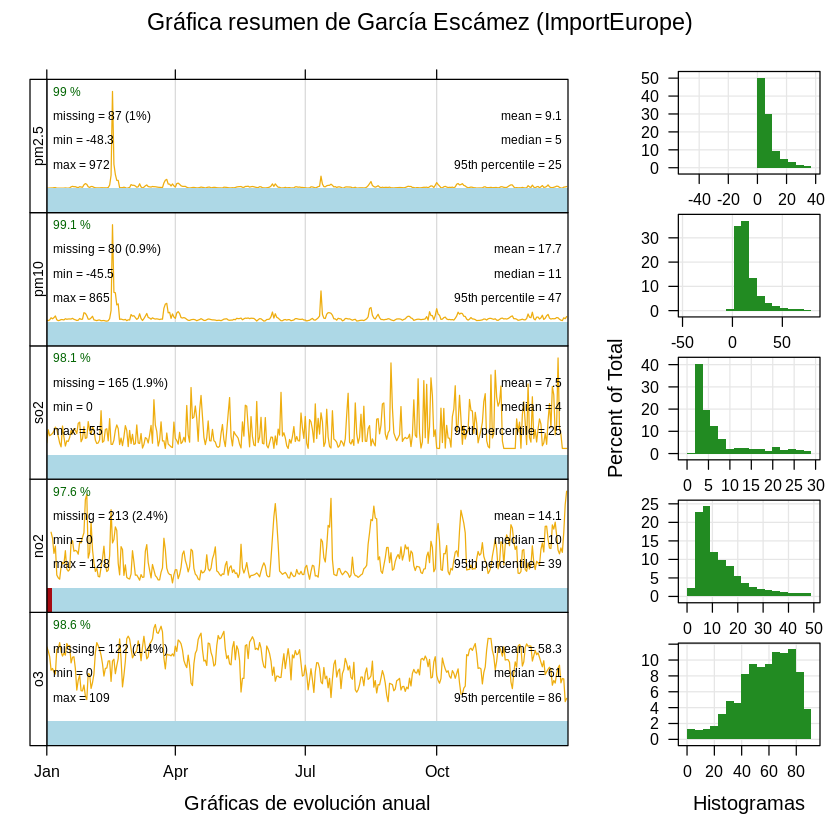

In [9]:
df_GarciEsca_import=subset(AQ_Canary_2021, code=="es2020a")
summaryPlot(subset(df_GarciEsca_import, select=c("date", "o3", "no2", "no","so2", "pm10","pm2.5")), 
  percentile=0.98, # que percentil queremos usar/representar
  na.len=24, # si hay más de 24 datos seguidos que no se encuentran, más de 24h en este caso, no aparece (barra granate)
  auto.text=FALSE, 
  xlab=c("Gráficas de evolución anual","Histogramas"), # etiqueta de los ejes x
  main="Gráfica resumen de García Escámez (ImportEurope)" # título de la gráfica
  )            


Nos dará los principales estadísticos (media, mediana, el percentil indicado, cuántos valores no están, valor mínimo y valor máximo), así como la representación en histograma (que también se puede "tunear", para ello visitar los diferentes enlaces indicados arriba.

**Uso de la función *timePlot(df)***

Gráficas temporales clásicas, pero con funcionalidades de Openair que facilitan el estudio de diferentes contaminantes a lo largo de una serie temporal, con variación de diferentes promedio, percentiles, etc.

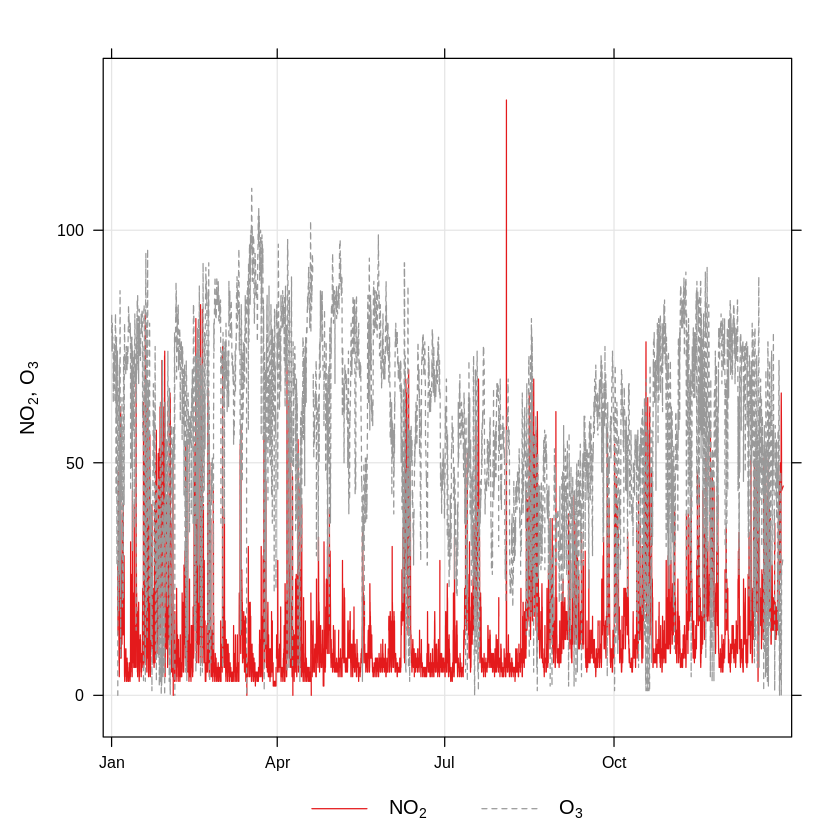

In [8]:
# el más simple, graficar 2 parámetros de nuestro conjunto en el periodo horario de origen, y en una misma gráfica
timePlot (df_GarciEsca_import, # nuestro dataframe 
  pollutant=c("no2","o3"), # los contaminantes que queremos plotear
  group=TRUE) # TRUE se plotearan los dos contaminantes en la misma gráfica, FALSE saldrán dos gráficas, una por contaminante

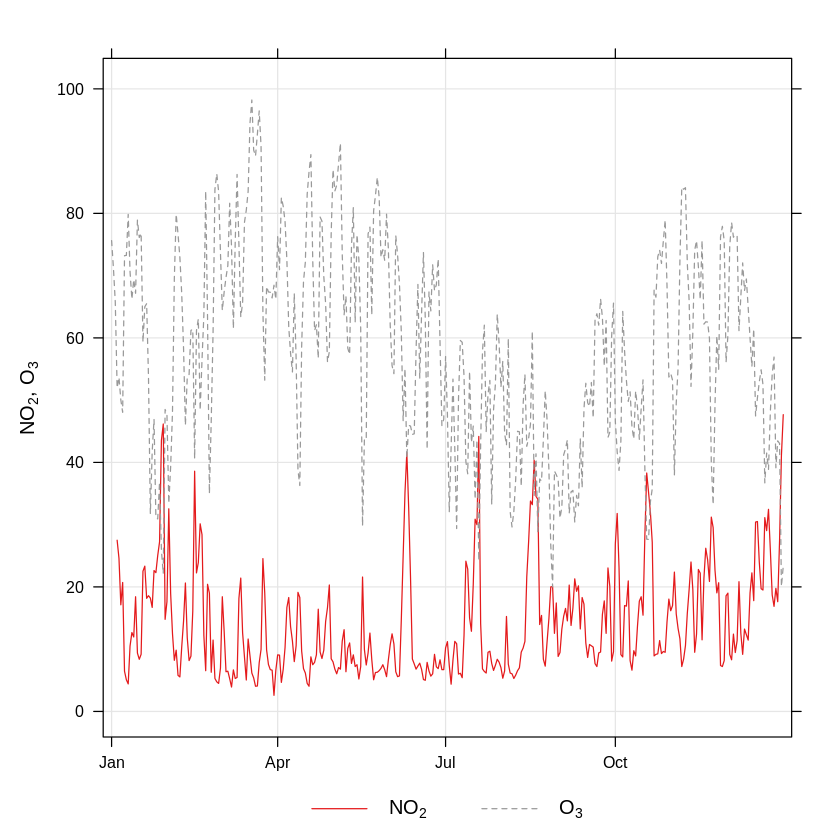

In [9]:
# sale muy ruidoso, quizás nos interesa más el promedio diario (o mensual "month")
timePlot (df_GarciEsca_import, 
  pollutant=c("no2", "o3"), 
  group=TRUE, 
  avg.time="day") # aquí podríamos promediar diario "day", semanal "week", mensual "month"

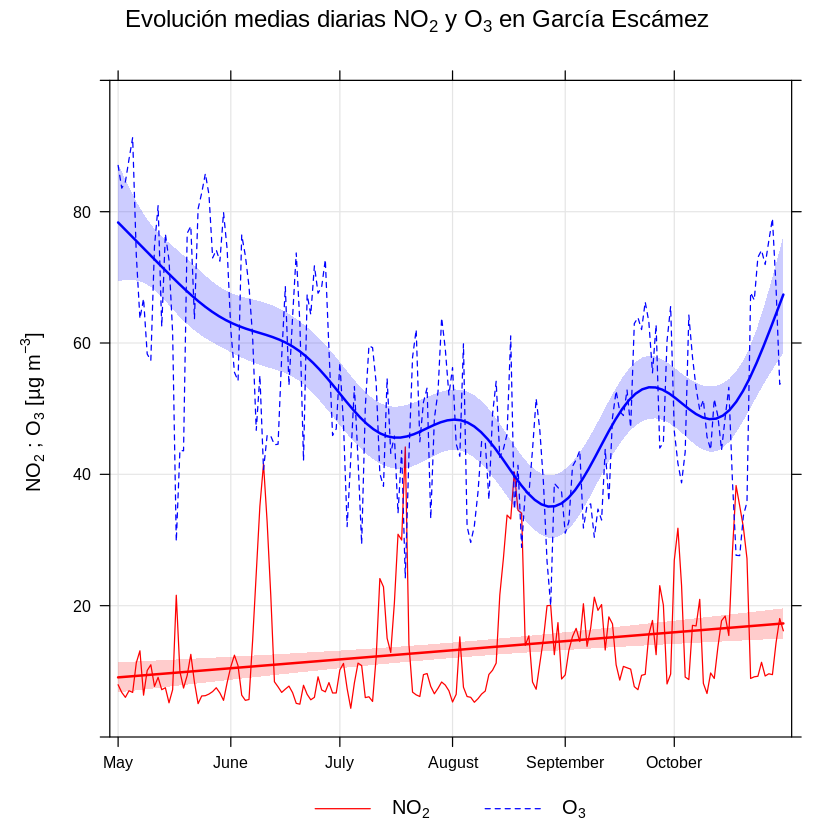

In [10]:
# seleccionar meses, añadir suavizados, para seguir estudiando el comportamiento del parámetro
# selectByDate es un argumento que podremos usar en más funciones, en este caso elegimos los meses de mayo a octbre
timePlot (selectByDate(df_GarciEsca_import,   # nuestro data frame 
  month=c(5,6,7,8,9,10)),                     # los meses que elegimos para representar usando selectByDate
  pollutant=c("no2", "o3"), 
  group=TRUE, 
  avg.time="day", 
  cols=c("red", "blue"),                      # colores de las gráficas
  smooth=TRUE,                                # aplicación de un suavizado
  date.breaks=6, 
  date.format="%B",                           # formato de la fecha
  ylab="NO2 ; O3 [ug/m3]", 
  main="Evolución medias diarias NO2 y O3 en García Escámez",
  ylim=c(0,100))                              # límites del eje Y


**Uso de la función *timeVariation(df)***

Si queremos analizar como se comporta el contaminante en un período cíclico como a escala estacional, mensual o diaria

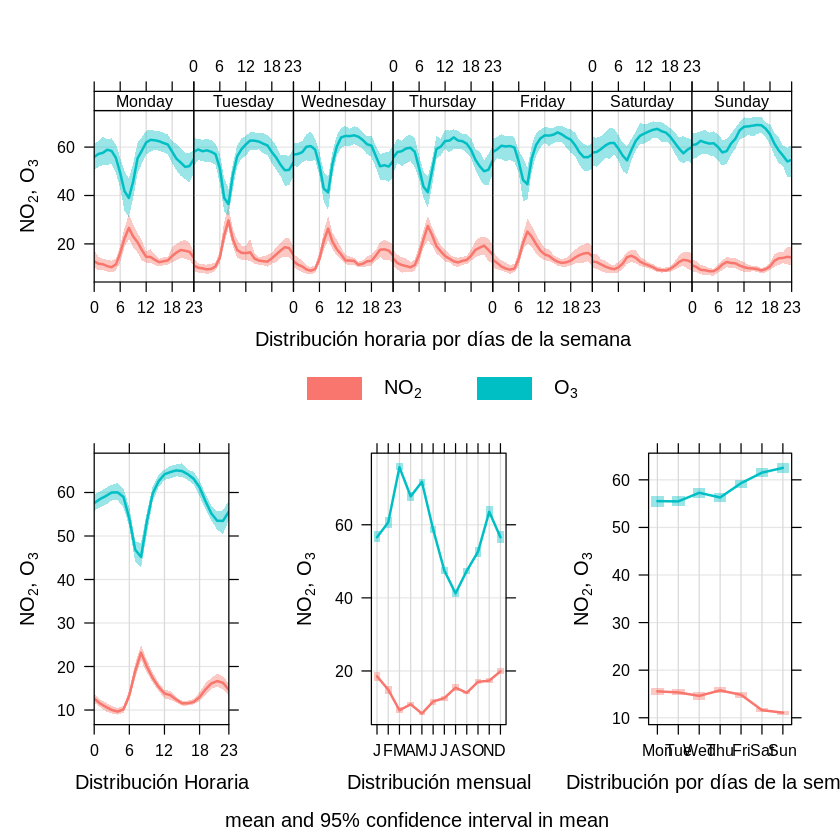

In [10]:
#ATENCIÓN hora UTC, no la local, se puede convertir usando local.time pero lo hará a la hora local británica
timeVariation(df_GarciEsca_import, 
  pollutant=c("no2", "o3"), 
  xlab=c("Distribución horaria por días de la semana","Distribución Horaria","Distribución mensual","Distribución por días de la semana"))


### INFORMES DE CALIDAD DEL AIRE

**Uso de la función *calendarPlot(df)***

Es una función que calcula las medias diarias de un año determinado para un parámetro, establecer una escala de colores para dichas medias, y las muestra con el color resultante cada uno de los días de un calendario de ese año.

*  Por contaminante
*  Por periodo
*  Calendario de valores máximos
*  Calendario de superaciones

Se puede realizar varias operaciones (argumentos) sobre lo anterior, x ej. 

elegir año ***year*** (hasta incluso elegir representar solo algunos meses ***month = c(1,12))***

elegir contaminante ***pollutant*** qué se muestra en el día del calendario annotate ***(“date”, “value”, “wd” …)***

si queremos resaltar los valores límite x ej. ***lim=50, col.lim= c("black", "white"), font.lim= c(1,2)***

si queremos que todas las figuras tengan la misma escala (x ej. ***limits = c(0,100)***)

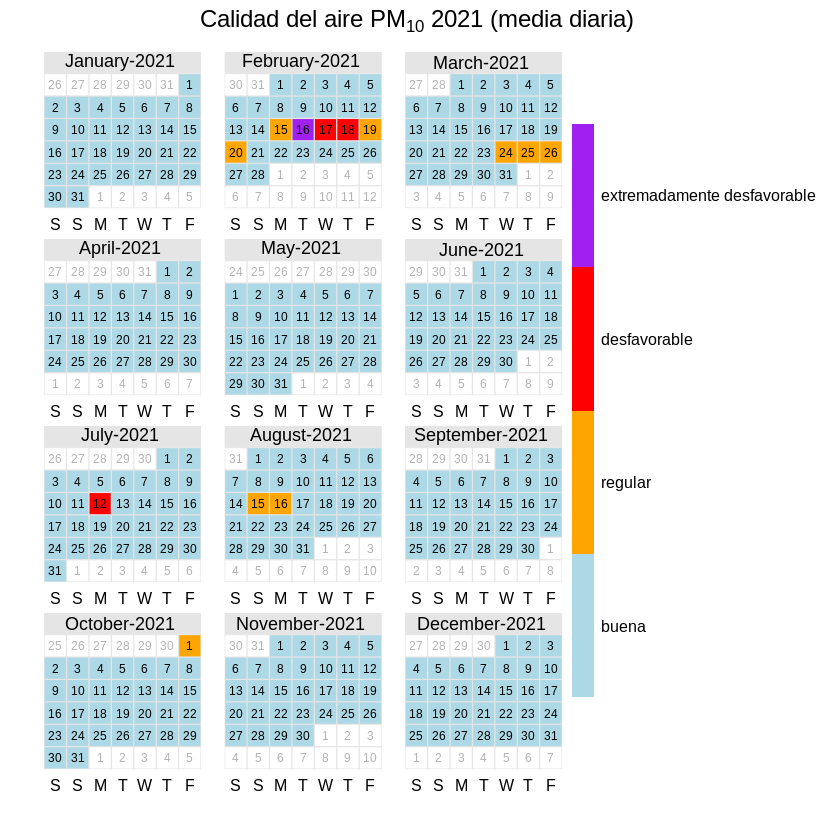

In [11]:
calendarPlot (df_GarciEsca_import, 
  pollutant = "pm10", 
  breaks = c(0, 50, 100, 150, 1000), # escala de información
  labels = c("buena", "regular", "desfavorable", "extremadamente desfavorable"),  # etiqueta de la escala
  cols = c("lightblue", "orange", "red",  "purple"), # colores en los días que estén en cada rango de la etiqueta
  statistic = "mean",   # representa la estadística sobre la cual se aplica la escala, puede ser también "max", etc.
  main="Calidad del aire PM10 2021 (media diaria)")


### SUPERACIONES
**Código para listar superaciones (qué estaciones, qué valores, cuántas veces..., junto con medias, percentiles...)**

**RECORDATORIO**
### Consulta de la ayuda de **RStudio**

Si se usa el entorno de RStudio, en el cuadrante inferior derecho  hay varias pestañas, una de ellas *help* donde podremos buscar información de todos los paquetes, funciones, etc. que argumentos admite, qué opciones tienen, etc.

**Uso de la función *pollutantRose(df)***

Para el ploteo de la rosa contaminante necesitamos un archivo que tenga la dirección del viento (wd) y la velocidad (ws)

(ejemplo, el fichero xlsx de 2015; o sustituir por el df que hayan cargado ustedes)

**Argumentos**

*mydata* A data frame containing fields ws and wd

*pollutant* Mandatory. A pollutant name corresponding to a variable in a data frame should be supplied e.g. pollutant = "nox".

*key.footer* Adds additional text/labels below the scale key. See key.header for further information.

*key.position* Location where the scale key is to plotted. Allowed arguments currently include “top”, “right”, “bottom” and “left”.

*key* Fine control of the scale key via drawOpenKey().

*breaks* Most commonly, the number of break points for pollutant concentrations. The default, 6, attempts to breaks the supplied data at approximately 6 sensible break points. However, breaks can also be used to set specific break points. For example, the argument breaks = c(0, 1, 10, 100) breaks the data into segments
<1, 1-10, 10-100, >100.

*paddle* Either TRUE or FALSE. If TRUE plots rose using ’paddle’ style spokes. If FALSE plots rose using ’wedge’ style spokes.

*seg* When paddle = TRUE, seg determines with width of the segments. For example, seg = 0.5 will produce segments 0.5 * angle.
normalise If TRUE each wind direction segment is normalised to equal one. This is useful for showing how the concentrations (or other parameters) contribute to each wind sector when the proportion of time the wind is from that direction is low.
A line showing the probability that the wind directions is from a particular wind sector is also shown.

*alpha* The alpha transparency to use for the plotting surface (a value between 0 and 1 with zero being fully transparent and 1 fully opaque). Setting a value below 1 can be useful when plotting surfaces on a map using the package openairmapss.

*plot* Should a plot be produced? FALSE can be useful when analysing data to extract plot components and plotting them in other ways

In [ ]:
pollutionRose(Canary_2015_xlsx, pollutant = "pm10", type = "year", statistic = "prop.mean")